# Le Debruiteur
* Jonas Freiburghaus
* Romain Capocasale
* He-Arc, INF3dlm-a
* Image Processing course
* 2019-2020

## Statistics

In [1]:
import os

from debruiteur.generator.datagenerator import DataGenerator
from debruiteur.preprocessing.preprocessor import make_original_dataframe, make_resized_dataframe, make_noised_dataframe
from debruiteur.noise.noise import GaussianNoise, PoissonNoise, UniformNoise, SaltPepperNoise, SquareMaskNoise, SpeckleNoise
from debruiteur.utils.utils import load_model, split_train_val_df
from debruiteur.noise.filters import gaussian_filter, wiener_filter, laplacian_filter, gaussian_weighted_substract_filter
from debruiteur.noise.filters import mean_filter, median_filter, conservative_filter, low_pass_filter, high_pass_filter
from debruiteur.statistics.statistics import compute_noise_reduction_method_statistics, compute_noise_type_statistics
from debruiteur.metrics.metrics import metrics_example

In [2]:
noise_class_list = [
    GaussianNoise(mean=0, std=20),
    PoissonNoise(),
    UniformNoise(amplitude=100),
    SaltPepperNoise(),
    SquareMaskNoise(mask_shape=(10, 10), freq=0.1),
    SpeckleNoise(),
]

### Load data

In [3]:
working_dir = os.path.abspath(os.getcwd())

df_original = make_original_dataframe(os.path.join(working_dir, "images"))
df_resized = make_resized_dataframe(df_original, img_shape=(100, 100), resized_path=os.path.join(working_dir, "resized_images"))
df_noised = make_noised_dataframe(df_resized, noise_class_list, os.path.join(working_dir, "noised_images"))

### Metrics

Mean squared error (MSE) :
$$\text{MSE} = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2$$

Normalized root mean squared error (NRMSE) :
$$\text{NRMSE} = \sqrt{\frac{1}{n} \sum_{i=1}^{n}\left(\log{\frac{\hat{y} + 1}{y + 1}}\right)^2}$$

Peak signal to noise ration (PSNR) :
$$\text{PSNR} = 10 \log_{10} \left( \frac{{MAX_{I}^2}}{MSE} \right)$$

Structural similarity (SSIM) :
$$\text{SSIM(x, y)} = \frac{(2\mu_x \mu_y + c_1)(2\sigma_{xy} + c_2)}{(\mu_x^2 + \mu_y^2 + c_1)(\sigma_x^2 + \sigma_y^2 + c_2)}$$

### Show metrics example

C:\Users\jonas.freiburg\Documents\Niveau3\imagerie\traitement_image\projet\ledebruiteur\debruiteur\metrics\metrics.py:65: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  ssim = metrics.structural_similarity(orignal_img, noised_img)


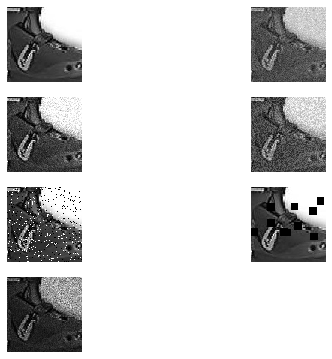

,Noise,MSE,NRMSE,PSNR,SSIM
0,GaussianNoise,404.694079,0.148148,22.059535,0.432669
1,PoissonNoise,243.662200,0.114954,24.262922,0.505953
2,UniformNoise,3312.642379,0.423856,12.929058,0.303072
3,SaltPepperNoise,2216.831500,0.346735,14.673477,0.278841
4,SquareMaskNoise,2170.195300,0.343068,14.765815,0.809742
5,SpeckleNoise,736.907895,0.199911,19.456672,0.508690


In [4]:
metrics_example(df_noised, noise_class_list)

You can see the score for each type of noise for each metric. We can notice that the type of noise that deteriorates the image the most is SpeckleNoise. We can also see that the Gaussian, Poisson noise is one of the filters that deteriorates the image the least. 

### Create data generator

In [5]:
stats_gen = DataGenerator(df_noised[0:20], batch_size=20)

### Load models

In [6]:
conv_ae_model = load_model(os.path.join(working_dir, "saved_models"), "conv_autoencoder.h5")
dense_ae_model = load_model(os.path.join(working_dir, "saved_models"), "dense_autoencoder.h5")
gan_model = load_model(os.path.join(working_dir, "saved_models"), "gan_generator.h5")

C:\Users\jonas.freiburg\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow_core\python\keras\layers\core.py:986: UserWarning: debruiteur.models.gan is not loaded, but a Lambda layer uses it. It may cause errors.
  , UserWarning)


### Noise reduction methods
After the output of the neural networks we apply a filter to smooth the image. Indeed, the images at the output of the neural network are a little blurred. These filters allow to reduce the blur. The filters used are : 
* Wiener filter
* Laplacian filter
* Gaussian Weigthed filter

In [7]:

noise_reduction_methods = [('Gaussian Filter', lambda img: gaussian_filter(img * 255)),
                           ('Mean Filter', lambda img: mean_filter(img * 255)),
                           ('Median Filter', lambda img: median_filter(img * 255)),
                           ('Conservative Filter', lambda img: conservative_filter(img * 255)),
                           ('Low pass FFT Filter', lambda img: low_pass_filter(img * 255)),
                           
                           ('Convolutional Autoencoder None', lambda x : conv_ae_model.predict(x.reshape(1, 100, 100, 1)) * 255),
                           ('Convolutional Autoencoder Wiener', lambda x : wiener_filter(conv_ae_model.predict(x.reshape(1, 100, 100, 1)).reshape(100,100) * 255)),
                           ('Convolutional Autoencoder Laplacian', lambda x : laplacian_filter(conv_ae_model.predict(x.reshape(1, 100, 100, 1)).reshape(100,100) * 255)),
                           ('Convolutional Autoencoder Gaussian Weighted', lambda x : gaussian_weighted_substract_filter(conv_ae_model.predict(x.reshape(1, 100, 100, 1)).reshape(100,100) * 255)),

                           ('Dense Autoencoder', lambda x : dense_ae_model.predict(x.reshape(1, 10000)) * 255),

                           ('Generative Adversarial Network None', lambda x : gan_model.predict(x.reshape(1, 100, 100, 1)) * 255),
                           ('Generative Adversarial Network Wiener', lambda x : wiener_filter(gan_model.predict(x.reshape(1, 100, 100, 1)).reshape(100,100) * 255)),
                           ('Generative Adversarial Network Laplacian', lambda x : laplacian_filter(gan_model.predict(x.reshape(1, 100, 100, 1)).reshape(100,100) * 255)),
                           ('Generative Adversarial Network Weighted', lambda x : gaussian_weighted_substract_filter(gan_model.predict(x.reshape(1, 100, 100, 1)).reshape(100,100) * 255))]

### Noise reduction methods metrics averaged on all kind of noises

In [8]:
compute_noise_reduction_method_statistics(stats_gen, noise_reduction_methods)

Compute finish for Gaussian Filter
Compute finish for Mean Filter
Compute finish for Median Filter
Compute finish for Conservative Filter
Compute finish for Low pass FFT Filter
Compute finish for Convolutional Autoencoder None
Compute finish for Convolutional Autoencoder Wiener
Compute finish for Convolutional Autoencoder Laplacian
Compute finish for Convolutional Autoencoder Gaussian Weighted
Compute finish for Dense Autoencoder
Compute finish for Generative Adversarial Network None
Compute finish for Generative Adversarial Network Wiener
Compute finish for Generative Adversarial Network Laplacian
Compute finish for Generative Adversarial Network Weighted


,MSE,NRMSE,PSNR,SSIM
Gaussian Filter,1329.173152,0.260626,18.202631,0.553287
Mean Filter,1591.244992,0.293272,16.924058,0.408735
Median Filter,1554.300015,0.286259,17.261898,0.434598
Conservative Filter,1279.248365,0.246813,18.876066,0.648794
Low pass FFT Filter,1227.034459,0.246544,18.773191,0.593923
Convolutional Autoencoder None,2721.356234,0.391336,14.390961,0.187798
Convolutional Autoencoder Wiener,3600.767919,0.456471,12.832394,0.150496
Convolutional Autoencoder Laplacian,2758.100050,0.394767,14.301804,0.176320
Convolutional Autoencoder Gaussian Weighted,2762.551183,0.393755,14.335962,0.189528
Dense Autoencoder,5596.324806,0.574819,10.735354,0.008347


### Noise reductions methods for each noise type
#### Structural similarity (SSIM)

A high SSIM is desired

In [9]:
df_stat_ssim = compute_noise_type_statistics(stats_gen, noise_reduction_methods, noise_class_list, "SSIM")
df_stat_ssim

Compute finish for Gaussian Filter
Compute finish for Mean Filter
Compute finish for Median Filter
Compute finish for Conservative Filter
Compute finish for Low pass FFT Filter
Compute finish for Convolutional Autoencoder None
Compute finish for Convolutional Autoencoder Wiener
Compute finish for Convolutional Autoencoder Laplacian
Compute finish for Convolutional Autoencoder Gaussian Weighted
Compute finish for Dense Autoencoder
Compute finish for Generative Adversarial Network None
Compute finish for Generative Adversarial Network Wiener
Compute finish for Generative Adversarial Network Laplacian
Compute finish for Generative Adversarial Network Weighted


,GaussianNoise,PoissonNoise,UniformNoise,SaltPepperNoise,SquareMaskNoise,SpeckleNoise
Gaussian Filter,0.477822,0.594880,0.467459,0.461130,0.568738,0.423297
Mean Filter,0.334825,0.425685,0.332730,0.352467,0.397599,0.297799
Median Filter,0.360238,0.460286,0.336427,0.527357,0.441198,0.313682
Conservative Filter,0.623435,0.711040,0.542507,0.514270,0.825458,0.587062
Low pass FFT Filter,0.576999,0.667295,0.541167,0.465155,0.645349,0.533686
Convolutional Autoencoder None,0.170657,0.172802,0.167828,0.133568,0.144035,0.050906
Convolutional Autoencoder Wiener,0.153242,0.143579,0.151217,0.123287,0.121134,0.089652
Convolutional Autoencoder Laplacian,0.154062,0.160932,0.152804,0.128121,0.139952,0.047140
Convolutional Autoencoder Gaussian Weighted,0.182608,0.176391,0.178821,0.138539,0.145706,0.054162
Dense Autoencoder,0.007715,0.008659,0.007831,0.008478,0.007742,0.007611


In [10]:
df_stat_ssim.mean(axis=1).sort_values()

Dense Autoencoder                              0.008006
Convolutional Autoencoder Wiener               0.130352
Convolutional Autoencoder Laplacian            0.130502
Convolutional Autoencoder None                 0.139966
Convolutional Autoencoder Gaussian Weighted    0.146038
Generative Adversarial Network Laplacian       0.163859
Generative Adversarial Network Wiener          0.320432
Mean Filter                                    0.356851
Median Filter                                  0.406531
Generative Adversarial Network None            0.455259
Generative Adversarial Network Weighted        0.488015
Gaussian Filter                                0.498888
Low pass FFT Filter                            0.571608
Conservative Filter                            0.633962
dtype: float64

#### Peak signal-to-noise ratio (PSNR)

A High PSNR is desired but not in all cases. It is often used as a reconstruction loss when compressing images.

In [11]:
df_stat_psnr = compute_noise_type_statistics(stats_gen, noise_reduction_methods, noise_class_list, "PSNR")
df_stat_psnr

Compute finish for Gaussian Filter
Compute finish for Mean Filter
Compute finish for Median Filter
Compute finish for Conservative Filter
Compute finish for Low pass FFT Filter
Compute finish for Convolutional Autoencoder None
Compute finish for Convolutional Autoencoder Wiener
Compute finish for Convolutional Autoencoder Laplacian
Compute finish for Convolutional Autoencoder Gaussian Weighted
Compute finish for Dense Autoencoder
Compute finish for Generative Adversarial Network None
Compute finish for Generative Adversarial Network Wiener
Compute finish for Generative Adversarial Network Laplacian
Compute finish for Generative Adversarial Network Weighted


,GaussianNoise,PoissonNoise,UniformNoise,SaltPepperNoise,SquareMaskNoise,SpeckleNoise
Gaussian Filter,17.737204,21.491647,18.247063,19.310966,15.725036,13.446155
Mean Filter,16.759011,19.313551,17.145060,18.531824,15.527770,12.942427
Median Filter,17.211851,20.058714,17.467064,20.095965,15.051523,12.910238
Conservative Filter,19.186584,24.178939,18.640867,15.864977,16.731168,13.856069
Low pass FFT Filter,18.652396,22.632896,18.817833,17.733438,16.663705,13.754239
Convolutional Autoencoder None,13.394846,13.375175,13.340671,12.106139,12.054274,8.845925
Convolutional Autoencoder Wiener,13.009035,12.285785,13.007490,11.540726,11.082185,10.757584
Convolutional Autoencoder Laplacian,13.274382,13.270463,13.239311,12.120894,12.355106,8.708507
Convolutional Autoencoder Gaussian Weighted,13.577523,13.347194,13.436870,12.114653,11.738948,8.830486
Dense Autoencoder,10.751270,10.719879,10.754181,10.731339,10.729974,10.671110


In [12]:
df_stat_psnr.mean(axis=1).sort_values()

Dense Autoencoder                              10.726292
Convolutional Autoencoder Wiener               11.947134
Convolutional Autoencoder Laplacian            12.161444
Convolutional Autoencoder Gaussian Weighted    12.174279
Convolutional Autoencoder None                 12.186172
Generative Adversarial Network Laplacian       12.602380
Generative Adversarial Network Weighted        13.370288
Generative Adversarial Network None            13.385781
Generative Adversarial Network Wiener          13.772089
Mean Filter                                    16.703274
Median Filter                                  17.132559
Gaussian Filter                                17.659679
Low pass FFT Filter                            18.042418
Conservative Filter                            18.076434
dtype: float64

#### Mean squared error (MSE)

A low MSE is desired.

In [13]:
df_stat_mse = compute_noise_type_statistics(stats_gen, noise_reduction_methods, noise_class_list, "MSE")
df_stat_mse

Compute finish for Gaussian Filter
Compute finish for Mean Filter
Compute finish for Median Filter
Compute finish for Conservative Filter
Compute finish for Low pass FFT Filter
Compute finish for Convolutional Autoencoder None
Compute finish for Convolutional Autoencoder Wiener
Compute finish for Convolutional Autoencoder Laplacian
Compute finish for Convolutional Autoencoder Gaussian Weighted
Compute finish for Dense Autoencoder
Compute finish for Generative Adversarial Network None
Compute finish for Generative Adversarial Network Wiener
Compute finish for Generative Adversarial Network Laplacian
Compute finish for Generative Adversarial Network Weighted


,GaussianNoise,PoissonNoise,UniformNoise,SaltPepperNoise,SquareMaskNoise,SpeckleNoise
Gaussian Filter,1124.570495,493.254421,993.518736,779.093287,1541.567639,3150.321034
Mean Filter,1433.028501,803.763127,1284.446356,955.902100,1831.839209,3295.935631
Median Filter,1231.553650,695.524695,1186.071972,687.841845,2250.392668,3350.129802
Conservative Filter,809.867014,252.853703,897.172107,1686.537083,1556.788410,2889.059361
Low pass FFT Filter,913.941910,366.405746,865.722041,1085.902576,1592.090731,2859.570051
Convolutional Autoencoder None,3129.040444,3034.636450,3039.936811,4022.361929,4308.368148,8725.844037
Convolutional Autoencoder Wiener,3417.657489,3929.002621,3396.565342,4663.474941,5110.703151,5725.055511
Convolutional Autoencoder Laplacian,3180.626613,3109.815786,3127.314652,4088.605817,3860.595761,8659.940213
Convolutional Autoencoder Gaussian Weighted,2963.625984,3050.478009,2931.232611,4060.741866,4525.568912,8597.734878
Dense Autoencoder,5570.849309,5616.525660,5569.376098,5604.436884,5629.916640,5675.435008


In [14]:
df_stat_mse.mean(axis=1).sort_values()

Low pass FFT Filter                            1280.605509
Gaussian Filter                                1347.054269
Conservative Filter                            1348.712947
Median Filter                                  1566.919105
Mean Filter                                    1600.819154
Generative Adversarial Network Wiener          2958.590017
Generative Adversarial Network None            3338.000018
Generative Adversarial Network Weighted        3473.986287
Generative Adversarial Network Laplacian       3910.805119
Convolutional Autoencoder Laplacian            4337.816474
Convolutional Autoencoder Gaussian Weighted    4354.897043
Convolutional Autoencoder Wiener               4373.743176
Convolutional Autoencoder None                 4376.697970
Dense Autoencoder                              5611.089933
dtype: float64

#### Normalized root mean squared error (NRMSE)

A low NRMSE is desired.

In [15]:
df_stat_nrmse = compute_noise_type_statistics(stats_gen, noise_reduction_methods, noise_class_list, "NRMSE")
df_stat_nrmse

Compute finish for Gaussian Filter
Compute finish for Mean Filter
Compute finish for Median Filter
Compute finish for Conservative Filter
Compute finish for Low pass FFT Filter
Compute finish for Convolutional Autoencoder None
Compute finish for Convolutional Autoencoder Wiener
Compute finish for Convolutional Autoencoder Laplacian
Compute finish for Convolutional Autoencoder Gaussian Weighted
Compute finish for Dense Autoencoder
Compute finish for Generative Adversarial Network None
Compute finish for Generative Adversarial Network Wiener
Compute finish for Generative Adversarial Network Laplacian
Compute finish for Generative Adversarial Network Weighted


,GaussianNoise,PoissonNoise,UniformNoise,SaltPepperNoise,SquareMaskNoise,SpeckleNoise
Gaussian Filter,0.254472,0.169755,0.243258,0.214495,0.326090,0.425347
Mean Filter,0.284917,0.217319,0.275639,0.238112,0.325120,0.443833
Median Filter,0.271618,0.200910,0.265566,0.201460,0.342025,0.450126
Conservative Filter,0.219445,0.121468,0.230254,0.319423,0.289252,0.407096
Low pass FFT Filter,0.235073,0.146780,0.227272,0.254640,0.293645,0.402684
Convolutional Autoencoder None,0.425577,0.425200,0.422716,0.489187,0.495308,0.718522
Convolutional Autoencoder Wiener,0.448570,0.481554,0.443707,0.523390,0.542175,0.577330
Convolutional Autoencoder Laplacian,0.426345,0.429614,0.428934,0.493857,0.485077,0.713890
Convolutional Autoencoder Gaussian Weighted,0.419573,0.425602,0.419047,0.490133,0.508238,0.708841
Dense Autoencoder,0.573488,0.575723,0.573323,0.575206,0.578540,0.578559


In [16]:
df_stat_nrmse.mean(axis=1).sort_values()

Low pass FFT Filter                            0.260016
Conservative Filter                            0.264490
Gaussian Filter                                0.272236
Median Filter                                  0.288617
Mean Filter                                    0.297490
Generative Adversarial Network Wiener          0.407936
Generative Adversarial Network Weighted        0.431281
Generative Adversarial Network None            0.433533
Generative Adversarial Network Laplacian       0.467967
Convolutional Autoencoder Gaussian Weighted    0.495239
Convolutional Autoencoder None                 0.496085
Convolutional Autoencoder Laplacian            0.496286
Convolutional Autoencoder Wiener               0.502788
Dense Autoencoder                              0.575807
dtype: float64

# Conclusion

As we can observe the conservative filter has the best score on all most all type of noises.  
It may be because the changes in the images are very small so it the denoised image is similar to the original image.  
This is particularly true when the images are not very noised and the performance would be different if the images had more noise.  

The generative adversial neural network reduces the noise quite well, but as the image is generated, the colors are sometimes different which is not the case of other filters.  
When we sum all these small differences pixelwise it is expected to have a high error.  
Even though the results are visually good.  

For each filter the metrics where computed on all kind of noises.  
Usually we should use a specific filter on a particular noise as they perform better on the approriate noise.  

Comparing the neural networks, the generative adversial neural network has the best performances.  
If we had a GPU with more RAM, we could increase the depth of the GAN by putting more convolutional blocks.  
This is also the reason why we reduced the image's size to 100x100 and used grayscale.  
An other improvement would be to implement the style loss in order to keep better texture details and so improve the performance.  

Another point to note is that the structural similarity has been criticized for not being more corelated to the human's perception as the mean squarred error.  
Comparing the images visually is sometimes more valuable than comparing metrics.  

This conclusion shouldn't be used to say that classical filters (gaussian etc) perform always better than neural networks in all cases.  